In [1]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import splitfolders
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

In [2]:
# Base data directory
base_dir = Path('/Users/tehreem/Desktop/Study/Projects/defungi')
source_dir = base_dir / 'data'

In [3]:
#Remove Corrupt Images
def remove_corrupt_images(directory):
    corrupted_files = []
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            normalized_name = filename.strip().lower()
            if normalized_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                file_path = os.path.join(dirpath, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except Exception as e:
                    corrupted_files.append(file_path)
                    print(f"Corrupt image found and deleted: {file_path} ({e})")
                    os.remove(file_path)
            else:
                print(f"Unknown file format ignoring: {filename}")
    print(f"Total corrupt images deleted: {len(corrupted_files)}" )

remove_corrupt_images(source_dir)

Total corrupt images deleted: 0


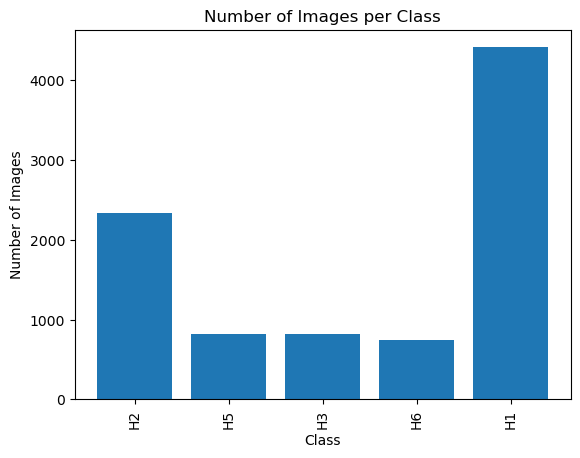

In [4]:
def histogram_of_class_count(class_counts):
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title("Number of Images per Class")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

def count_images(source_dir):
    image_counts = {}
    for class_dir in source_dir.iterdir():  # <-- FIXED LINE
        if class_dir.is_dir():
            image_count = len([
                file for file in class_dir.iterdir()
                if file.is_file() and file.suffix.lower() in ['.jpg', '.jpeg', '.png']
            ])
            image_counts[class_dir.name] = image_count
    return image_counts

image_counts2 = count_images(source_dir)
histogram_of_class_count(image_counts2)


In [5]:
#Print the image count for each class
for class_name, count in image_counts2.items():
    print(f"{class_name}: {count} images")

H2: 2334 images
H5: 818 images
H3: 819 images
H6: 739 images
H1: 4404 images


You should always split your data into train, validation, and test sets first. Then, apply data augmentation only to the training set.
Never augment your validation or test sets.

## **Recommended Approach: Stratified Splitting + Augmentation**

### **1. Split Strategy: Stratified 80-10-10**

Use **stratified splitting** to preserve class ratios in all splits. This ensures each class is represented proportionally in train/val/test sets.


| Class | Total | Train (80%) | Val (10%) | Test (10%) |
| :-- | :-- | :-- | :-- | :-- |
| H1 | 4404 | 3523 | 440 | 441 |
| H2 | 2334 | 1867 | 233 | 234 |
| H3 | 819 | 655 | 82 | 82 |
| H5 | 818 | 654 | 82 | 82 |
| H6 | 739 | 591 | 74 | 74 |

**Why?**

- Prevents val/test sets from having too few samples of minority classes (H3/H5/H6)
- Maintains real-world class distribution during evaluation

---

### **2. Augment Minority Classes in Training Set**

After splitting, apply **data augmentation** **only to the training set** to balance class counts:


| Class | Original Train | After Augmentation |
| :-- | :-- | :-- |
| H3 | 655 | ~2000 (3x) |
| H5 | 654 | ~2000 (3x) |
| H6 | 591 | ~2000 (3.4x) |

**Augmentation Techniques:**

```python
# Example using TensorFlow
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
```


---

### **3. Add Class Weighting**

#### What is `compute_class_weight`?

- **Purpose:**
It calculates numeric weights for each class in your data, especially useful for imbalanced datasets.
- **How it works:**
    - You give it your class labels and the class distribution in your data.
    - If you use `class_weight="balanced"`, it computes weights so that rare classes get higher weights and common classes get lower weights.
    - Example: If class 0 is much more frequent than class 1, class 1 will get a higher weight.
- **Output:**
    - An array (or dict) mapping each class to a weight value, e.g., `{0: 0.5, 1: 2.0}`.

---

#### What is `class_weight` in `model.fit`?

- **Purpose:**
It tells the model’s training process to use the given weights for each class when computing the loss.
- **How it works:**
    - You pass a dictionary like `{0: 0.5, 1: 2.0}` to the `class_weight` parameter in `model.fit`.
    - The model will penalize mistakes on class 1 more than class 0, according to the weights you provide.

---

#### How do they work together?

- **Typical Workflow:**

1. Use `compute_class_weight` to calculate the appropriate weights for your data.
2. Pass those weights as the `class_weight` argument when calling `model.fit`.

**Example:**

```python
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Compute weights
weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=[0,0,0,1])
class_weight_dict = dict(zip([0,1], weights))

# Step 2: Use in model training
model.fit(X, y, class_weight=class_weight_dict)
```


---


| Function/Parameter | What it does | Where to use it |
| :-- | :-- | :-- |
| `compute_class_weight` | Calculates class weights from data | Before training, to get the weights |
| `model.fit(..., class_weight=...)` | Applies the weights during model training | During model training |



| Method | Pros | Cons | Best For |
| :-- | :-- | :-- | :-- |
| Random 80-10-10 | Simple to implement | Val/test may lack H3/H5/H6 | Balanced datasets |
| Equal % per class | Forces balanced evaluation | Distorts real-world scenario | Medical/security applications |
| **Stratified + Aug** | Real-world eval + fair training | Requires extra processing | Most imbalanced cases |

---

## In Short

- **`compute_class_weight`**: Calculates what the weights should be.
- **`class_weight` in `model.fit`**: Actually uses those weights to influence training.

## Using `splitfolders` to split into train, val & test

- It splits your folder of images into train/val/test
- It preserves the class ratios (stratified split)
- It works directly on folders, so you don’t need to write custom code

- This will create `output/train`, `output/val`, and `output/test`, each with H1, H2, etc. inside, preserving the original class distribution.

---

## How It Works

- **Input:**

```
data/
  H1/
  H2/
  H3/
  ...
```

- **Output:**

```
output/
  train/
    H1/
    H2/
    ...
  val/
    H1/
    H2/
    ...
  test/
    H1/
    H2/
    ...
```

- **Stratified splitting** ensures the class distribution in train/val/test matches your original data.
- No need to write custom code for copying files or managing splits.
- Works for any number of classes.

In [6]:
#Splitting into train val and test
splitfolders.ratio(
    'data',                # source directory with H1, H2, ...
    output="output",       # output directory
    seed=1337,             # for reproducibility
    ratio=(.8, .1, .1)     # train:val:test split
)

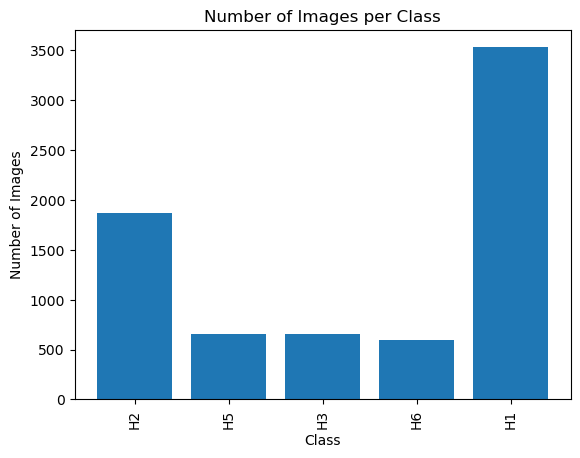

In [7]:
image_counts_train = count_images(base_dir/'output/train')
histogram_of_class_count(image_counts_train)

## **What is `y_train`?**

- `y_train` should be a list or array containing the class labels for all images in your **training set** (before augmentation).
- Example: If you have 5 images in training, and their classes are H1, H2, H1, H3, H2, then
`y_train = ['H1', 'H2', 'H1', 'H3', 'H2']`

In [3]:
# Calculating class weights before augmentation
# y_train is the list/array of original training labels (before augmentation)
train_dir = Path(base_dir/'output/train')  # path to your training data folder

# Step 1: Collect labels
y_train = []
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        label = class_dir.name
        for img_file in class_dir.iterdir():
            if img_file.is_file() and img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                y_train.append(label)

# Step 2: Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)

{'H1': 0.4138518308260006, 'H2': 0.7809319764327799, 'H3': 2.2259541984732825, 'H5': 2.229357798165138, 'H6': 2.467005076142132}


## Should you augment images **before** making a dataset (offline), or **after** (on-the-fly/online) while training?

### **1. Augmenting in the Directory (Offline Augmentation)**

- You create new, augmented images and save them into your directory, making your dataset physically bigger.
- When you load your dataset, you are loading both original and augmented images.
- **Pros:**
    - Faster training (no CPU bottleneck during training).
    - You always know exactly what images are in your dataset.
    - Good if you want to inspect or share the exact dataset.
- **Cons:**
    - Takes up more disk space.
    - Augmentation variety is fixed (you can't generate new variations during training).
    - Risk of data leakage if you augment before splitting into train/val/test (augmented copies of the same image can end up in both train and test, which is bad!).

---

### **2. Augmenting After Making the Dataset (Online/In-Memory Augmentation)**

- You load your original images into a dataset, then apply random augmentations on-the-fly during training (using libraries like Keras, PyTorch, Albumentations, etc.).
- **Pros:**
    - Saves disk space, since only original images are stored.
    - Every epoch, the model can see new, unique variations of each image (more variety).
    - No risk of data leakage if you only augment the training set.
- **Cons:**
    - Training can be slower if your CPU can't keep up with the augmentations.
    - Harder to reproduce exactly the same augmented dataset unless you fix random seeds.

---

## **Best Practice**

- **Split your data into train, val, and test sets first.**
- **Apply augmentation only to the training set.**
- **Prefer online (in-memory) augmentation** during training, unless you have a specific reason to save augmented images to disk.

---

## **Comparison Table**

| Method | Disk Space | Flexibility | Risk of Data Leakage | Training Speed | Reproducibility |
| :-- | :-- | :-- | :-- | :-- | :-- |
| Offline (directory) | High | Low | High (if split after) | Fast | High |
| Online (in dataset/code) | Low | High | Low (if split before) | Slower (CPU) | Lower (random) |

------
You have a **class imbalance** problem:

- H1: 4404 images (majority)
- H2: 2334 images
- H3: 819 images
- H5: 818 images
- H6: 739 images (minority)

Here’s the best approach, explained simply:

---

## **1. Always Split First**

- Split your data into train, val, and test sets, preserving class ratios (stratified split).
- **Never** augment before splitting, to avoid data leakage.

---

## **2. Combine These Strategies**

### **A. Use Class Weights**

- Compute class weights from your original training set.
- Pass these weights to your model’s loss function (e.g., `class_weight` in Keras, or `class_weight='balanced'` in scikit-learn).
- This makes the model pay more attention to minority classes.


### **B. Use Per-Class Data Augmentation**

- Apply **stronger augmentation to minority classes** (H3, H5, H6) and lighter augmentation to majority classes (H1, H2).
- This increases the effective number of samples for rare classes, helping the model learn better from them.
- Example: For H6, use more aggressive transformations (rotations, flips, color jitter, etc.) and generate more augmented images per original.


### **C. (Optional) Oversampling**

- You can oversample minority classes in the training set (repeat their images more often).
- Do this only in the training set, never in val/test.


### **D. Try Ensemble Methods**

- Algorithms like Random Forests and Gradient Boosting can handle imbalance well, especially with class weights.
- For deep learning, use class weights and augmentation as above.

---

## **3. Avoid These Pitfalls**

- **Do not** augment or oversample before splitting your data.
- **Do not** only use accuracy as your metric; also track recall, precision, and AUC for minority classes.

---

## **Simple Workflow**

1. **Stratified split**: Make train/val/test with same class ratios.
2. **Compute class weights** using original train set.
3. **Set up data augmentation**:
    - More aggressive for H3, H5, H6
    - Lighter for H1, H2
4. **Train your model** using:
    - Online augmentation (in-memory)
    - Class weights in loss function

---

## **Summary Table**

| Method | What it Does | When to Use |
| :-- | :-- | :-- |
| Class Weights | Penalizes errors on minority classes more | Always (deep learning) |
| Per-class Augmentation | Makes more/different samples for rare classes | Always (training only) |
| Oversampling | Repeats minority class images in training | Optional (training only) |
| Ensemble Methods | Combines multiple models, handles imbalance | Optional |


---

## **Key Point**

**The best results usually come from combining class weights and per-class augmentation, applied only to the training set after splitting.**
This helps the model learn from all classes, even when some are rare.

# Should oversampling be done before augmentation or after?

Here's the optimal approach for combining **oversampling** and **class-specific augmentation** in your imbalanced dataset scenario:

---

### * Workflow**

1. **Augment First → Then Oversample**
    - **Augment** original minority class images (H3/H5/H6) with aggressive transformations.
    - **Oversample** the augmented images to match majority class counts.
2. **Why This Order?**
    - If you oversample first (duplicate images), then augment, you risk creating nearly identical copies of the same image.
    - Augmenting first ensures **every duplicated image is unique**, maximizing diversity.

---

## **Step-by-Step Implementation**

### **1. Define Class-Specific Augmentation Pipelines**

```python
import tensorflow as tf

# Light augmentations for H1/H2 (majority classes)
light_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.Rescaling(1./255)
])

# Aggressive augmentations for H3/H5/H6 (minority classes)
aggressive_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.4),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255)
])
```


### **2. Apply Augmentation to Original Data**

```python
def apply_class_specific_aug(image, label):
    if label in ['H3', 'H5', 'H6']:
        return aggressive_aug(image), label
    else:
        return light_aug(image), label

# Assuming you have a tf.data.Dataset object `original_train_ds`
augmented_ds = original_train_ds.map(apply_class_specific_aug)
```


### **3. Oversample Minority Classes**

```python
# Calculate oversampling ratios (example: H6 needs 3x more samples)
oversample_factors = {
    'H1': 1,  # No oversampling
    'H2': 1,
    'H3': 3,  # Augment + oversample to 3x original count
    'H5': 3,
    'H6': 4
}

# Filter and concatenate datasets
final_train_ds = tf.data.Dataset.sample_from_datasets([
    augmented_ds.filter(lambda x, y: y == class_name).repeat(oversample_factors[class_name])
    for class_name in ['H1', 'H2', 'H3', 'H5', 'H6']
])
```


### **4. Add Online Augmentation (Optional)**

```python
# Apply mild random augmentations during training
online_aug = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomCrop(224, 224)
])

final_train_ds = final_train_ds.map(
    lambda x, y: (online_aug(x), y), 
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
```


---

## **Key Advantages**

| Step | Benefit |
| :-- | :-- |
| Augment First | Ensures every oversampled image is unique |
| Oversample After | Balances class counts without duplicating identical images |
| Online Augmentation | Adds extra variability during training without affecting stored data |


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_dir = Path(base_dir/'output/train')
val_dir = Path(base_dir/'output/val')
test_dir = Path(base_dir/'output/test')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names

Found 7290 files belonging to 5 classes.
Found 908 files belonging to 5 classes.
Found 916 files belonging to 5 classes.


2025-06-09 12:40:11.138928: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-09 12:40:11.138954: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-09 12:40:11.138960: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-09 12:40:11.138973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-09 12:40:11.138981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


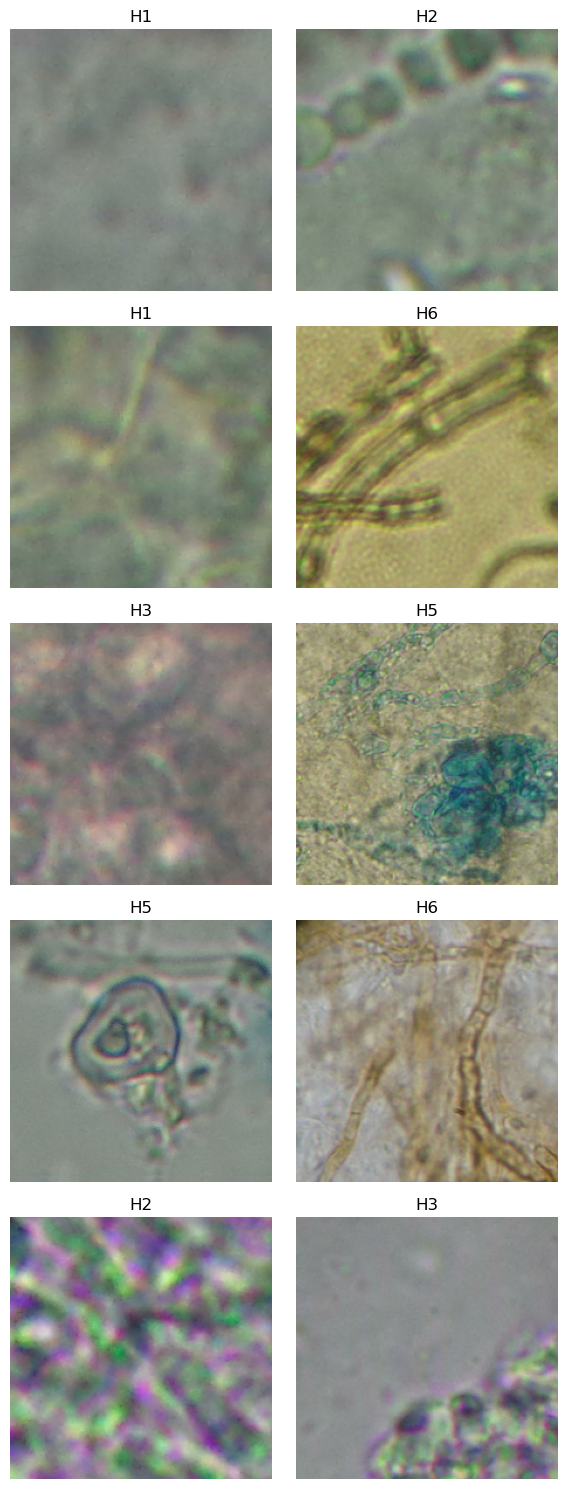

In [10]:
def show_images_per_class(dataset, class_names, images_per_class=2):
    plt.figure(figsize=(images_per_class * 3, len(class_names) * 3))
    class_count = {cls: 0 for cls in class_names}
    displayed = 0
    total_needed = images_per_class * len(class_names)
    for images, labels in dataset.unbatch().batch(1):
        label_idx = np.argmax(labels.numpy())
        class_name = class_names[label_idx]
        if class_count[class_name] < images_per_class:
            ax = plt.subplot(len(class_names), images_per_class, displayed + 1)
            plt.imshow(images.numpy().astype("uint8")[0])
            plt.title(class_name)
            plt.axis("off")
            class_count[class_name] += 1
            displayed += 1
            if displayed >= total_needed:
                break
    plt.tight_layout()
    plt.show()

show_images_per_class(train_ds, class_names, images_per_class=2)

In [6]:
print("Class order:", class_names)

Class order: ['H1', 'H2', 'H3', 'H5', 'H6']


In [5]:
# 1. Light augmentation pipeline for majority classes
light_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.Rescaling(1./255)
])

# 2. Aggressive augmentation pipeline for minority classes
aggressive_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.4),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255)
])

# 3. Define minority classes
minority_classes = ['H3', 'H5', 'H6']

# 4. Get their indices based on class_names order
minority_indices = [class_names.index(cls) for cls in minority_classes]

# 5. Convert to TensorFlow constant
minority_indices_tensor = tf.constant(minority_indices, dtype=tf.int64)

# 6. Augmentation function
def class_specific_aug(image, label):
    class_idx = tf.argmax(label)
    is_minority = tf.reduce_any(tf.equal(class_idx, minority_indices_tensor))
    return tf.cond(
        is_minority,
        lambda: (aggressive_aug(image), label),
        lambda: (light_aug(image), label)
    )

# Apply to dataset by unbatching first
aug_train_ds = (
    train_ds
    .unbatch()  # Split batches into individual images
    .map(class_specific_aug, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)  # Re-batch after augmentation
    .prefetch(tf.data.AUTOTUNE)
)


### Oversampling minority class
class weights are: {np.str_('H1'): np.float64(0.4138518308260006), np.str_('H2'): np.float64(0.7809319764327799), np.str_('H3'): np.float64(2.2259541984732825), np.str_('H5'): np.float64(2.229357798165138), np.str_('H6'): np.float64(2.467005076142132)}

class weights are inversely proportional to class frequencies.
| Class | Class Weight | Repeat Factor | Explanation |
| :-- | :-- | :-- | :-- |
| H1 | 0.41 | 1x | Majority class (no oversampling) |
| H2 | 0.78 | 2x | Slightly underrepresented |
| H3 | 2.23 | 5x | Underrepresented |
| H5 | 2.23 | 5x | Underrepresented |
| H6 | 2.47 | 6x | Most underrepresented |

1. **H1 (4404 samples)**:
    - Already the majority class → no oversampling needed (`1x`).
2. **H2 (2334 samples)**:
    - ~50% of H1’s size → mild oversampling (`2x`) to reach ~4668 samples.
3. **H3/H5 (819/818 samples)**:
    - ~18% of H1’s size → oversample `5x` to reach ~4095 samples.
4. **H6 (739 samples)**:
    - ~17% of H1’s size → oversample `6x` to reach ~4434 samples.

In [6]:
repeat_factors = {
    'H1': 1,
    'H2': 2,
    'H3': 5,
    'H5': 5,
    'H6': 6
}
datasets = []

for i, class_name in enumerate(class_names):
    # Unbatch → filter → rebatch
    class_ds = (
        aug_train_ds
        .unbatch()
        .filter(lambda x, y: tf.equal(tf.argmax(y), i))
        .batch(BATCH_SIZE)
    )
    class_ds = class_ds.repeat(repeat_factors[class_name])
    datasets.append(class_ds)

balanced_train_ds = tf.data.experimental.sample_from_datasets(datasets)
balanced_train_ds = balanced_train_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


In [ ]:
for batch in balanced_train_ds.take(1):
    # Usually, batch is a tuple: (images, labels)
    images, labels = batch
    
    print(f"Images type: {type(images)}")
    print(f"Images shape: {images.shape}")
    
    print(f"Labels type: {type(labels)}")
    print(f"Labels shape: {labels.shape}")
    
    # For labels, to see values:
    print("Labels sample (numpy):", labels.numpy()[:5])


In [ ]:
# This is crashing the kernel
for sample in balanced_train_ds.take(1):
    print("Data types:", type(sample), " | Length:", len(sample))
    print("Data types inside batch:", [type(i) for i in sample])

#So these lines are not able to execute
images, labels = next(iter(balanced_train_ds))
print("Label dtype:", labels.dtype)
print("Label sample:", labels[:5])


In [ ]:
# This is crashing the kernel
for images, labels in balanced_train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Sample labels:", labels.numpy()[:5])


In [14]:
# Prepare Validation and Test Sets do not use augmentation—just rescale:
rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])

val_ds = val_ds.map(lambda x, y: (rescale(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (rescale(x), y)).prefetch(tf.data.AUTOTUNE)


In [15]:
# Building the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


original `class_weight_dict` is:

```python
{
    np.str_('H1'): np.float64(0.4138518308260006),
    np.str_('H2'): np.float64(0.7809319764327799),
    np.str_('H3'): np.float64(2.2259541984732825),
    np.str_('H5'): np.float64(2.229357798165138),
    np.str_('H6'): np.float64(2.467005076142132)
}
```

**Keras expects class weights as a dictionary with integer keys** (class indices), not string class names (if we use just without converting, we get TypeError: can only concatenate str (not "int") to str). The integer keys must correspond to the order in `class_names` (from your dataset).

---

## **Need to Convert the Class Weight Dict for Keras**

`class_names` is:

```python
class_names = ['H1', 'H2', 'H3', 'H5', 'H6']
```

We convert dictionary like this:


In [16]:
# original dict with string keys
class_weight_dict_str = {
    'H1': 0.4138518308260006,
    'H2': 0.7809319764327799,
    'H3': 2.2259541984732825,
    'H5': 2.229357798165138,
    'H6': 2.467005076142132
}

# Convert to integer keys for Keras
class_weight_dict = {
    class_names.index(cls): float(weight)
    for cls, weight in class_weight_dict_str.items()
}

print(class_weight_dict)

{0: 0.4138518308260006, 1: 0.7809319764327799, 2: 2.2259541984732825, 3: 2.229357798165138, 4: 2.467005076142132}


In [ ]:
#Train the model
model.fit(
    balanced_train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict  # Use the converted class weights
)


Epoch 1/10
